In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [3]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [5]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


<AxesSubplot:title={'center':'Rates for CAD/JPY'}, xlabel='Date'>

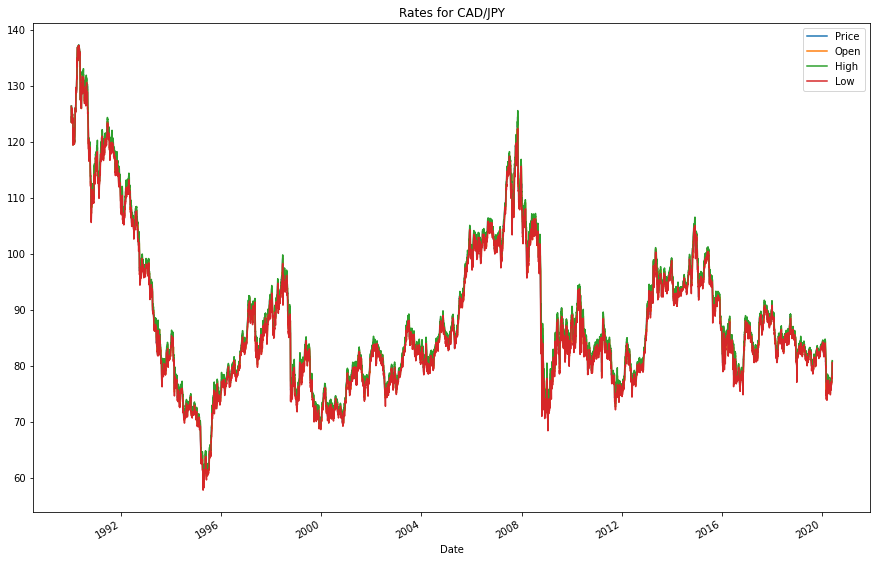

In [7]:
cad_jpy_df.plot(title='Rates for CAD/JPY',figsize = (15,10))

# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:title={'center':'Price for CAD/JPY'}, xlabel='Date'>

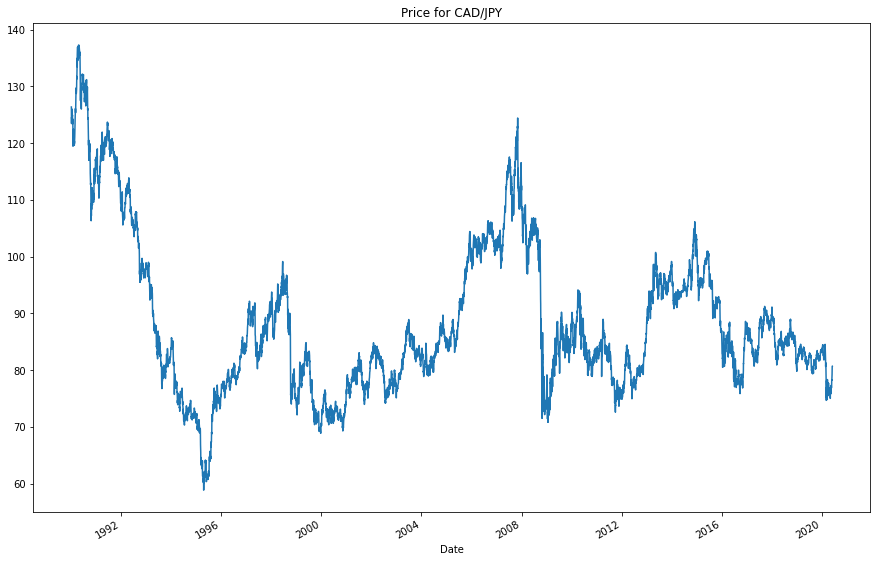

In [8]:
# Plot just the "Price" column from the dataframe:
cad_jpy_df.Price.plot(title='Price for CAD/JPY',figsize = (15,10))

<AxesSubplot:title={'center':'Price Moving Average'}, xlabel='Date'>

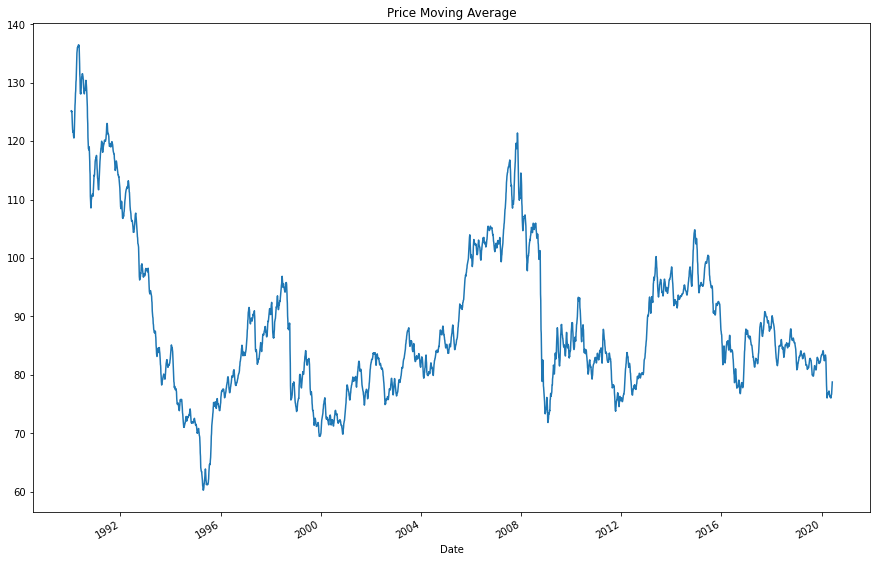

In [9]:
# Moving average. Each value is the average of previous 10 values.
cad_jpy_df.Price.rolling(window=10).mean().plot(title='Price Moving Average',figsize = (15,10))

<AxesSubplot:title={'center':'Price Exponentially-Weighted Moving Average'}, xlabel='Date'>

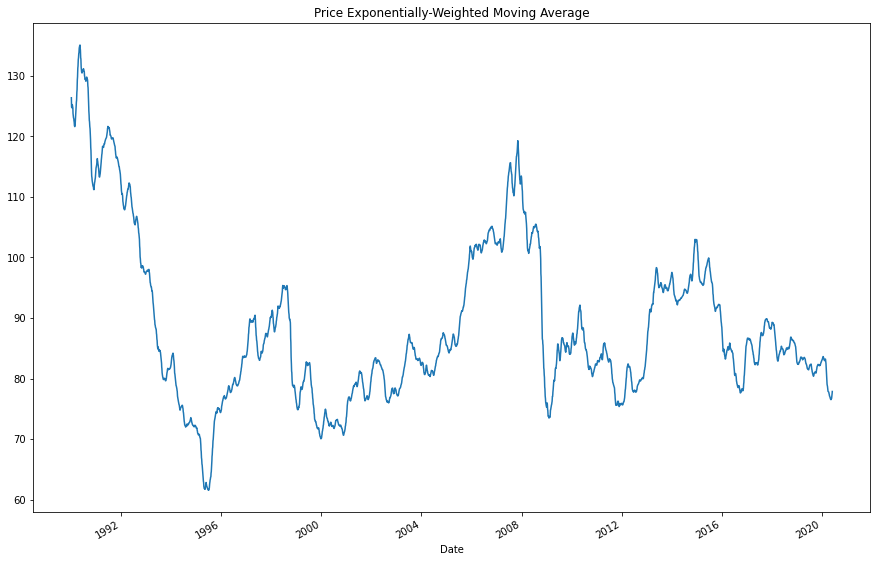

In [10]:
# Exponentially-Weighted Moving Average
cad_jpy_df.Price.ewm(halflife=10).mean().plot(title='Price Exponentially-Weighted Moving Average',figsize = (15,10))

**Question:** Do you see any patterns, long-term and/or short? 

**Answer:** After the steep decline in 1996, the price had fluctuated to a High and then a Low in a 4 year cycle

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [11]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
ts_noise, ts_trend = sm.tsa.filters.hpfilter(cad_jpy_df.Price)

In [12]:
cad_jpy_append = cad_jpy_df
cad_jpy_append['noise'] = ts_noise
cad_jpy_append['trend'] = ts_trend 
cad_jpy_append.head(2)

,Price,Open,High,Low,noise,trend
Date,,,,,,
1990-01-02,126.37,126.31,126.37,126.31,0.519095,125.850905
1990-01-03,125.30,125.24,125.30,125.24,-0.379684,125.679684


<AxesSubplot:title={'center':'Price Trend'}, xlabel='Date'>

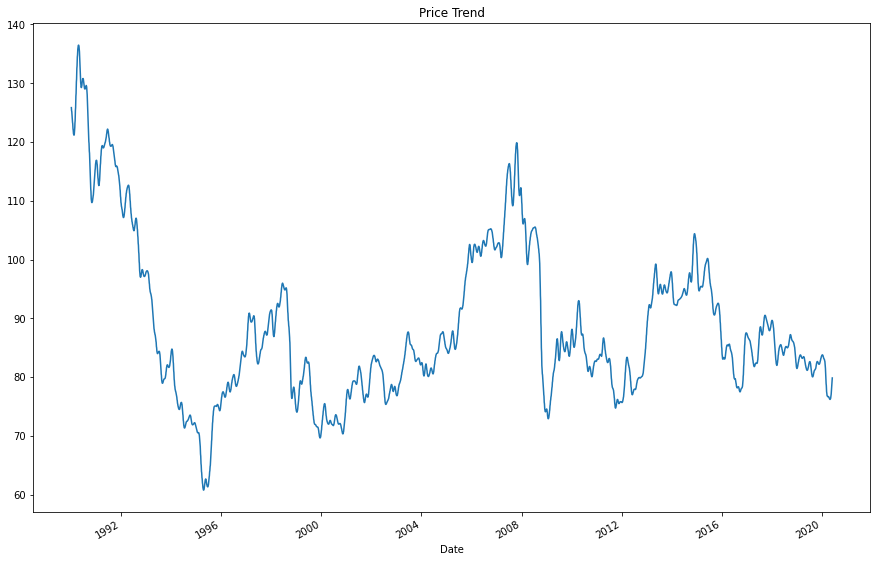

In [13]:
# Plot the trend
ts_trend.plot(title='Price Trend',figsize = (15,10))

<AxesSubplot:title={'center':'Price Noise'}, xlabel='Date'>

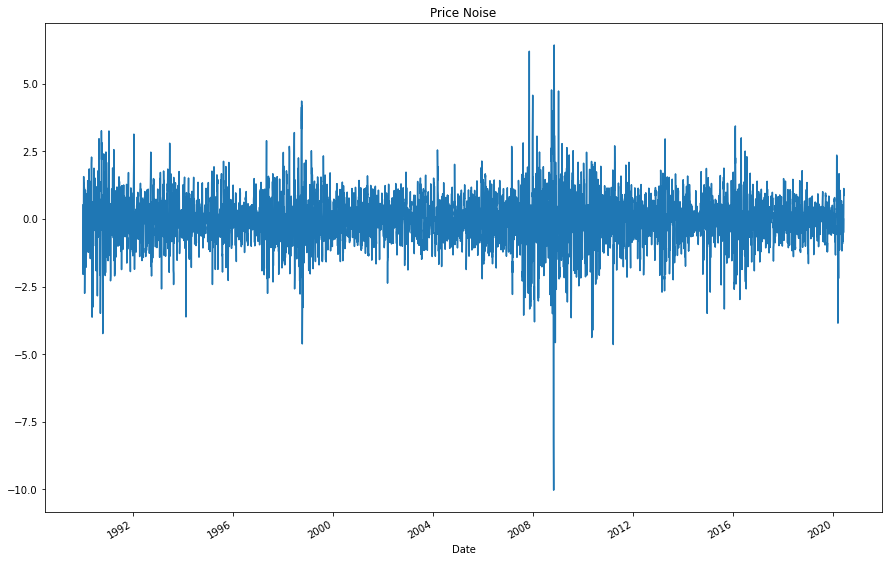

In [15]:
# Plot the noise
ts_noise.plot(title='Price Noise',figsize = (15,10))

In [16]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
cad_jpy_trend = cad_jpy_append.drop(columns=["Open", "High", "Low"])

In [10]:
cad_jpy_trend.head()

,Price,noise,trend
Date,,,
1982-01-05,184.65,-0.731015,185.381015
1982-01-06,185.06,-0.726912,185.786912
1982-01-07,186.88,0.687648,186.192352
1982-01-08,186.58,-0.016423,186.596423
1982-01-11,187.64,0.641354,186.998646


In [17]:
cad_jpy_trend_current = cad_jpy_trend.loc['2015 Jan':]
cad_jpy_trend_price = cad_jpy_trend_current.drop(columns=['noise'])
cad_jpy_trend_price.head()

,Price,trend
Date,,
2015-01-01,103.12,101.596073
2015-01-02,102.25,101.304283
2015-01-05,101.70,100.991800
2015-01-06,100.04,100.660865
2015-01-07,100.93,100.314161


<AxesSubplot:title={'center':'Price v Trend'}, xlabel='Date'>

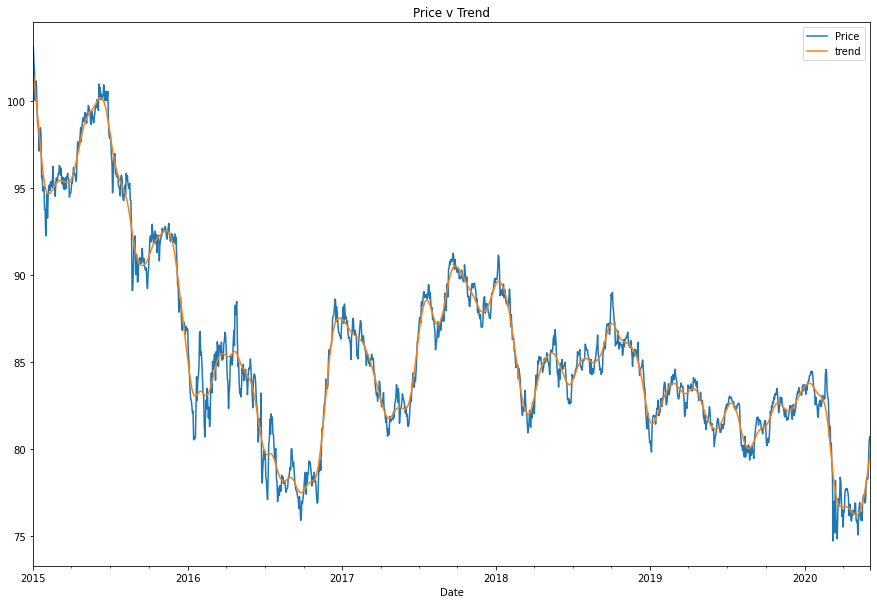

In [18]:
cad_jpy_trend_price.plot(title='Price v Trend',figsize = (15,10))

**Question:** Do you see any patterns, long-term and/or short?

**Answer:** There is a long-term decrease in the price but in the short-term there are continous highs and lows and possiblities to make money.

<AxesSubplot:title={'center':'Noise'}, xlabel='Date'>

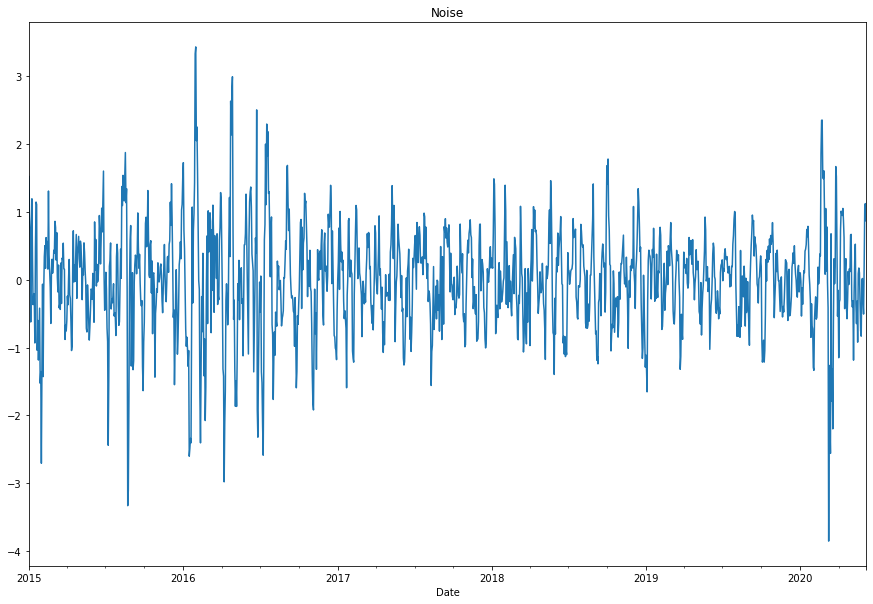

In [19]:
# Plot the Settle Noise
cad_jpy_noise = cad_jpy_trend_current.loc[:, 'noise']
cad_jpy_noise.plot(title='Noise',figsize = (15,10))

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [20]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [21]:
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results
results = model.fit()

<AxesSubplot:title={'center':'Price Forecast'}>

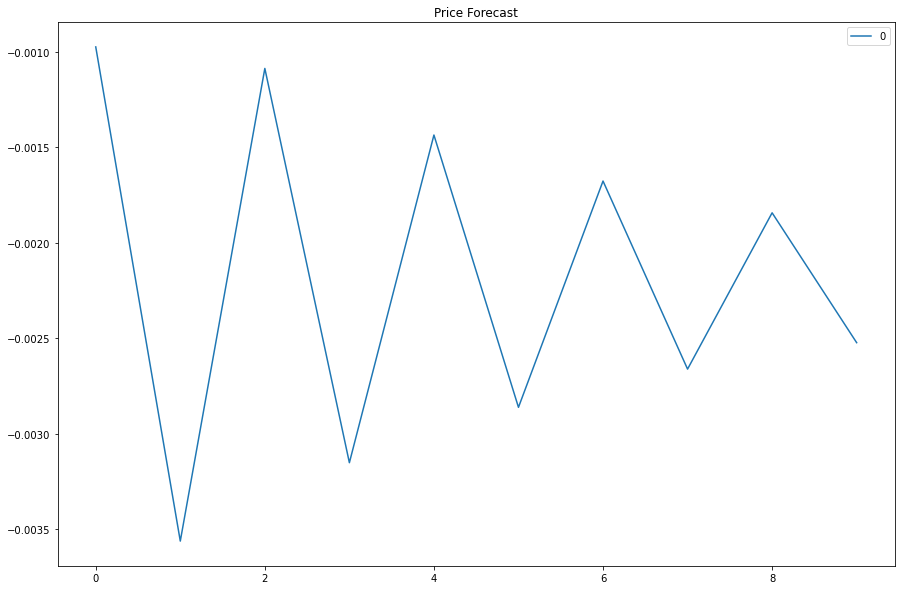

In [22]:
pd.DataFrame(results.forecast(steps=10)[0]).plot(title='Price Forecast',figsize = (15,10))

In [17]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 9965
Model:                     ARMA(2, 1)   Log Likelihood              -11924.111
Method:                       css-mle   S.D. of innovations              0.801
Date:                Mon, 22 Feb 2021   AIC                          23858.222
Time:                        19:30:33   BIC                          23894.256
Sample:                             0   HQIC                         23870.421
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0051      0.008     -0.649      0.517      -0.020       0.010
ar.L1.y       -0.8439      0.204     -4.129      0.000      -1.244      -0.443
ar.L2.y       -0.0161      0.012     -1.334      0.182      -0.040       0.008
ma.L1.y        0.8201      0.204      4.019      0.000       0.420       1.220
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2130           +0.0000j            1.2130            0.5000
AR.2          -51.3642           +0.0000j           51.3642            0.5000
MA.1           -1.2193           +0.0000j            1.2193            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'Price Forecast'}>

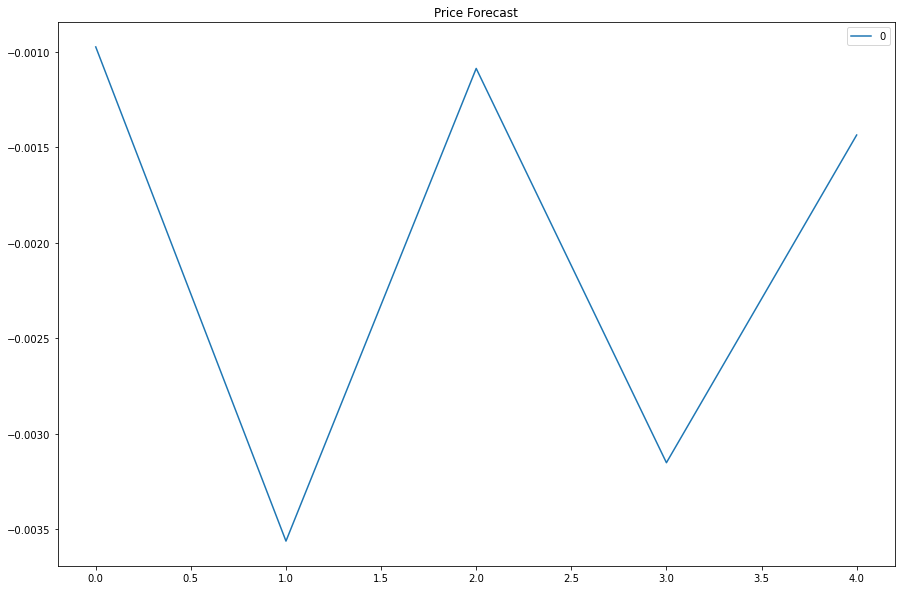

In [23]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title='Price Forecast',figsize = (15,10))

**Question:** Based on the p-value, is the model a good fit?

**Answer:** the model does accurately forecasts the High and the Lows as well as show a narrowing on the rate at which the price increases.

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

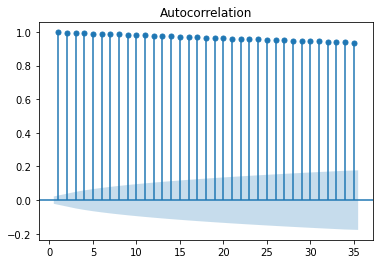

In [24]:
# Plot the autocorrelation of the Settle Prices
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(cad_jpy_trend.Price, zero=False, lags=35);

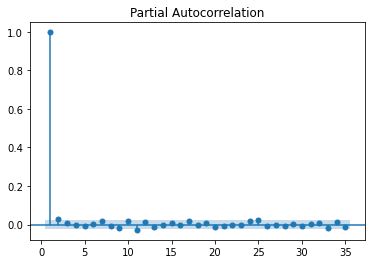

In [25]:
# Plot the partial autocorrelation of the returns
plot_pacf(cad_jpy_trend.Price, zero=False, lags=35);

In [26]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(cad_jpy_trend.Price.values, order=(1, 1, 1))

# Fit the model
results = model.fit()

In [25]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 9965
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -11737.904
Method:                       css-mle   S.D. of innovations              0.786
Date:                Mon, 22 Feb 2021   AIC                          23483.808
Time:                        19:37:43   BIC                          23512.635
Sample:                             1   HQIC                         23493.567
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0103      0.009     -1.163      0.245      -0.028       0.007
ar.L1.D.y      0.9494      0.046     20.762      0.000       0.860       1.039
ma.L1.D.y     -0.9430      0.048    -19.482      0.000      -1.038      -0.848
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0533           +0.0000j            1.0533            0.0000
MA.1            1.0605           +0.0000j            1.0605            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'Future Price Forecast'}>

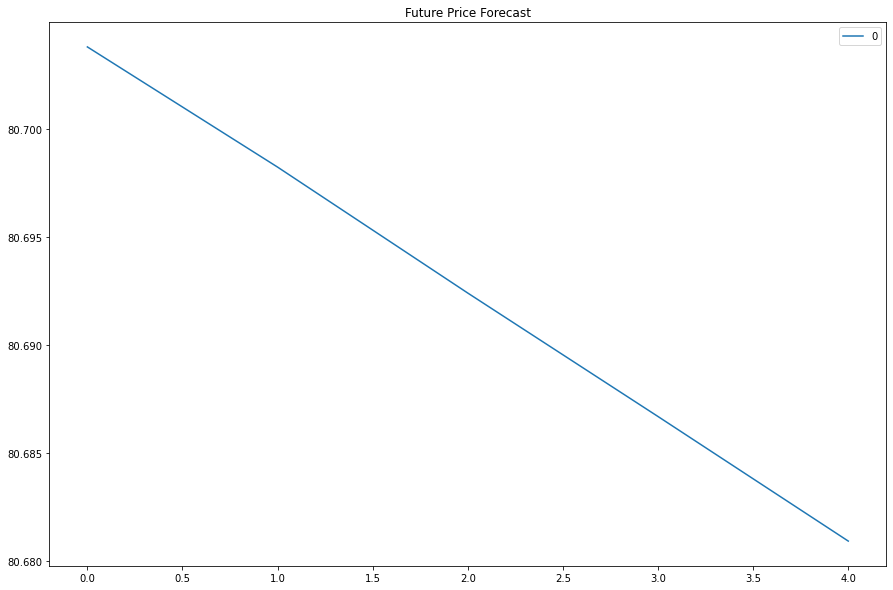

In [27]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title='Future Price Forecast',figsize = (15,10))

**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

**Answer:** The Model Forecast indicates the Japanese Yen is going to decrease and will hit 80,680

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [28]:
from arch import arch_model

ModuleNotFoundError: No module named 'arch'

In [29]:
# Estimate a GARCH model:
model = arch_model(cad_jpy_trend.Price, mean="Zero", vol="GARCH", p=1, q=1)
# Fit the model
results = model.fit(disp="on")

NameError: name 'arch_model' is not defined

In [111]:
# Summarize the model results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -46703.2
Distribution:                  Normal   AIC:                           93412.5
Method:            Maximum Likelihood   BIC:                           93433.4
                                        No. Observations:                 7929
Date:                Fri, Jan 22 2021   Df Residuals:                     7926
Time:                        00:06:52   Df Model:                            3
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega        159.8900      9.922     16.115  1.986e-58  [1.404e+02,1.793e+02]
alpha[1]       0.9784  2.112e-02     46.320      0.000      [  0.937,  1.020]
beta[1]        0.0000  2.220e-02      0.000      1.000 [-4.352e-02,4.352e-02]
=============================================================================

Covariance estimator: robust
"""

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [112]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [33]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [113]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
forecasts = results.forecast(start=last_day, horizon=forecast_horizon)
forecasts

In [115]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,1283.085252,1284.896255,1286.665583,1288.394255,1290.08326


In [116]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04 00:00:00
h.1,1283.085252
h.2,1284.896255
h.3,1286.665583
h.4,1288.394255
h.5,1290.083260


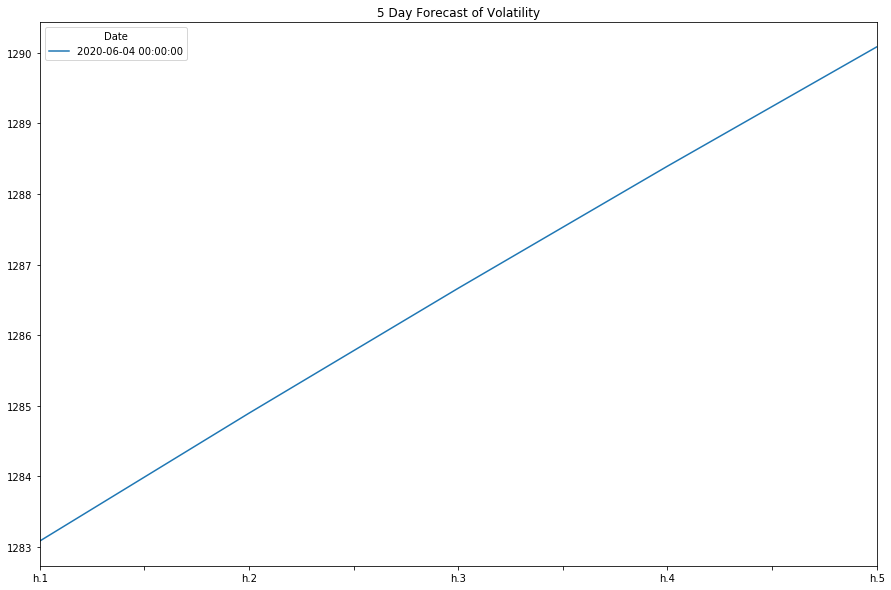

In [117]:
# Plot the final forecast
final.plot(title='5 Day Forecast of Volatility',figsize = (15,10))

**Question:** What does the model forecast will happen to volatility in the near term?

**Answer:** In the near term there is an indication of an increase of volatility.

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

    * Due to the Yen forecasted to decrease as well as the Volitility is set to increase. Now wouldn't be a good time buy the yen.

2. Is the risk of the yen expected to increase or decrease?
    * The risk of the Yen is expected to increase and is more volatile

3. Based on the model evaluation, would you feel confident in using these models for trading?
    * Yes these models give quite a forecast of the Japanese Yen.